In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed
from scipy.integrate import odeint
import math
import random
import itertools
import seaborn as sns

/home/anagha/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
num_of_nodes = 3
possible_initial_conditions = []
l = list(itertools.product([0, 1], repeat=num_of_nodes))
for i in range(len(l)):
    possible_initial_conditions.append(list(l[i]))  
    
possible_initial_conditions = np.array(possible_initial_conditions)                                                           

group_map = {
    'A': {'101', '111'},
    'B': {'100', '110'},
    'C': {'010', '011'},
    'D': {'000', '001'}
}

def get_group(state):
    state_str = ''.join(str(bit) for bit in state)
    for group_name, states in group_map.items():
        if state_str in states:
            return group_name
    return None  


In [91]:

def update_states(states, adjacency_matrix, rho=0.0, w=0):
    states = np.array(states)
    new_states = []

    for i in range(len(states)):
        input_sum = np.dot(adjacency_matrix[i], states) + w

        if input_sum > 0:
            # Probability of 1 = 1 - rho
            new_state = 1 if random.random() < (1 - rho) else 0

        elif input_sum < 0:
            # Probability of 0 = 1 - rho
            new_state = 0 if random.random() < (1 - rho) else 1

        else:
            # Probability of keeping current state = 1 - rho
            new_state = states[i] if random.random() < (1 - rho) else 1 - states[i]

        new_states.append(new_state)

    return new_states


#------------------------

def run_simulation(initial_states, adjacency_matrix, max_iterations=20, rho=0.0, w=0):
    states = initial_states[:]
    history = [states]

    for _ in range(max_iterations):
        new_states = update_states(states, adjacency_matrix, rho, w)
        history.append(new_states)
        states = new_states

    return history
#-------------------------------------

def normalize_cycle(cycle):
    """Return the lex smallest rotation of a cycle as a tuple of tuples."""
    cycle = [tuple(state) for state in cycle]
    n = len(cycle)
    rotations = [tuple(cycle[i:] + cycle[:i]) for i in range(n)]
    return min(rotations)

#-----------------------------------------------------------
def all_attractors_stochastic(adjacency_matrix, rho=0.5, trials_per_ic=10):
    fixed_point_basins = dict()
    cycle_basins = dict()

    for i in range(len(possible_initial_conditions)):
        initial_state = tuple(possible_initial_conditions[i])

        for _ in range(trials_per_ic):
            history = run_simulation(list(initial_state), adjacency_matrix, rho=rho)

            for cycle_len in range(1, len(history) // 2 + 1):
                tail = history[-cycle_len:]
                prev_tail = history[-2 * cycle_len:-cycle_len]

                if tail == prev_tail:
                    if cycle_len == 1:
                        state = tuple(tail[0])
                        fixed_point_basins.setdefault(state, []).append(initial_state)
                    else:
                        normalized = normalize_cycle(tail)
                        cycle_basins.setdefault(normalized, []).append(initial_state)
                    break

    result = []

    result = []

    for fp, basin in fixed_point_basins.items():
        result.append({
            "type": "fixed_point",
            "state": list(fp),
            "group": get_group(fp),
            "frequency": len(basin),
            "probability": len(basin) / (trials_per_ic * len(possible_initial_conditions))
        })

    for cyc, basin in cycle_basins.items():
        result.append({
            "type": "cycle",
            "length": len(cyc),
            "states": [list(state) for state in cyc],
            "groups": [get_group(s) for s in cyc],
            "frequency": len(basin),
            "probability": len(basin) / (trials_per_ic * len(possible_initial_conditions))
        })

    return result



    

In [48]:
import numpy as np
import itertools
from collections import Counter

def build_transition_matrix(adjacency_matrix, rho=0.1, trials_per_state=1000):
    num_nodes = len(adjacency_matrix)
    all_states = list(itertools.product([0, 1], repeat=num_nodes))  
    index_map = {tuple(state): idx for idx, state in enumerate(all_states)}
    T = np.zeros((len(all_states), len(all_states)))

    for i, state in enumerate(all_states):
        counts = Counter()

        for _ in range(trials_per_state):
            next_state = update_states(list(state), adjacency_matrix, rho=rho)
            j = index_map[tuple(next_state)]
            counts[j] += 1

        for j, count in counts.items():
            T[i, j] = count / trials_per_state

    return T, all_states


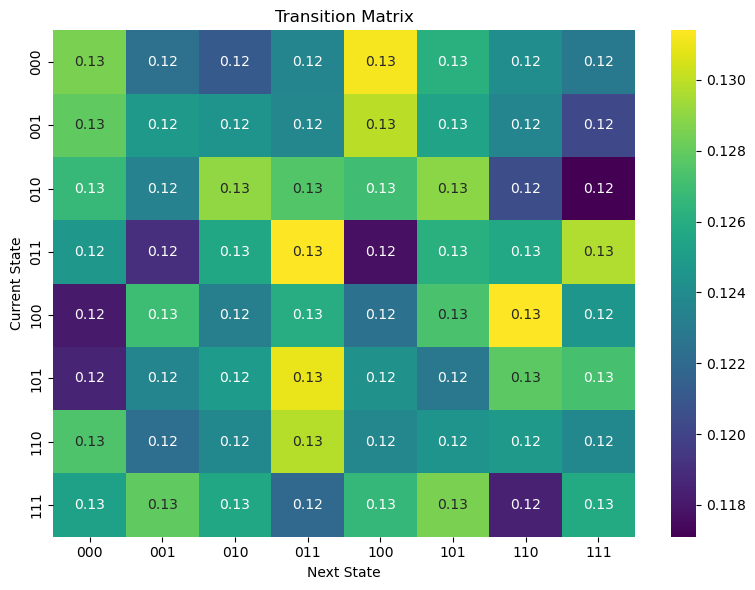

In [88]:
all_combinations = list(itertools.product([-1, 0, 1], repeat=9))
index_of_interesting_matrix = 3000
this_combiantion = all_combinations[index_of_interesting_matrix]
this_matrix = np.array(this_combiantion).reshape(3, 3) 
T, states = build_transition_matrix(this_matrix, rho=0.5, trials_per_state=10000)
plot_transition_matrix(T, states)

In [89]:
T

array([[0.1285, 0.1224, 0.1211, 0.1236, 0.1312, 0.1262, 0.1241, 0.1229],
       [0.1279, 0.1248, 0.1245, 0.1237, 0.1299, 0.1254, 0.1236, 0.1202],
       [0.1267, 0.1234, 0.129 , 0.1275, 0.127 , 0.1289, 0.1204, 0.1171],
       [0.1247, 0.119 , 0.1256, 0.1314, 0.1177, 0.1262, 0.1257, 0.1297],
       [0.1181, 0.1269, 0.1232, 0.126 , 0.1225, 0.1273, 0.1314, 0.1246],
       [0.1185, 0.1236, 0.1249, 0.1309, 0.1243, 0.1228, 0.1278, 0.1272],
       [0.1274, 0.1222, 0.1238, 0.1298, 0.1237, 0.1245, 0.1248, 0.1238],
       [0.1253, 0.1279, 0.1256, 0.1219, 0.1266, 0.1285, 0.1184, 0.1258]])

In [69]:
this_matrix

array([[-1,  0,  0],
       [-1,  0, -1],
       [-1,  0, -1]])

In [120]:
initial_states = [0,0,0]

run_simulation(initial_states, this_matrix, max_iterations=20, rho=0.7, w=0)

[[0, 0, 0],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [0, 1, 1],
 [1, 1, 0],
 [1, 1, 1],
 [0, 0, 1],
 [0, 1, 0],
 [0, 0, 1],
 [1, 1, 1],
 [0, 1, 1],
 [1, 1, 0],
 [1, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 1, 1]]

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_transition_matrix(T, states):
    state_labels = [''.join(map(str, s)) for s in states]
    plt.figure(figsize=(8, 6))
    sns.heatmap(T, xticklabels=state_labels, yticklabels=state_labels, cmap='viridis', annot=True, fmt=".2f")
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.title("Transition Matrix")
    plt.tight_layout()
    plt.show()


In [56]:
all_combinations = list(itertools.product([-1, 0, 1], repeat=9))
index_of_interesting_matrix = 303
this_combiantion = all_combinations[index_of_interesting_matrix]
this_matrix = np.array(this_combiantion).reshape(3, 3) 

result = all_attractors_stochastic(this_matrix, rho=0.0, trials_per_ic=10)
 
result

[{'type': 'fixed_point',
  'state': [0, 0, 0],
  'group': 'D',
  'frequency': 30,
  'probability': 0.375},
 {'type': 'fixed_point',
  'state': [0, 1, 1],
  'group': 'C',
  'frequency': 10,
  'probability': 0.125},
 {'type': 'cycle',
  'length': 2,
  'states': [[0, 0, 1], [0, 1, 0]],
  'groups': ['D', 'C'],
  'frequency': 40,
  'probability': 0.5}]